In [4]:
from pyke import KeplerTargetPixelFile
%matplotlib inline

In [116]:
import numpy as np

In [37]:
import matplotlib.pyplot as plt

In [19]:
from oktopus import UniformPrior, JointPrior

In [25]:
from pyke import PRFPhotometry, SceneModel
from pyke.utils import KeplerQualityFlags

In [26]:
tpf = KeplerTargetPixelFile('https://archive.stsci.edu/missions/k2/target_pixel_files/c12/246100000/99000/ktwo246199087-c12_lpd-targ.fits.gz',
                            quality_mask=KeplerQualityFlags.HARDEST_BITMASK)

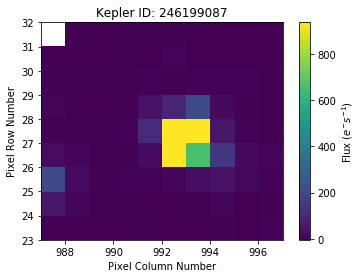

In [27]:
tpf.plot()

In [28]:
prf = tpf.get_prf_model()

In [73]:
prior_column = UniformPrior(lb=990, ub=996, name='column')
prior_row = UniformPrior(lb=25, ub=30, name='row')
prior_flux = UniformPrior(lb=4e3, ub=2e4, name='flux')
prior_bkg = UniformPrior(lb=1, ub=2e3, name='bkg')

In [59]:
prior = JointPrior(prior_flux, prior_column, prior_row, prior_bkg)

In [60]:
scene = SceneModel(prfs=[prf])

In [61]:
phot = PRFPhotometry(scene_model=scene, prior=prior)

In [62]:
results = phot.fit(tpf.flux + tpf.flux_bkg)

  0%|          | 0/3379 [00:00<?, ?it/s]/Users/jvmirca/anaconda3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
 35%|███▍      | 1176/3379 [00:44<01:23, 26.34it/s]/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1851: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1852: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
100%|██████████| 3379/3379 [02:12<00:00, 25.41it/s]


In [63]:
flux = results[:, 0]
col = results[:, 1]
row = results[:, 2]
bkg = results[:, 3]

(5000, 6000)

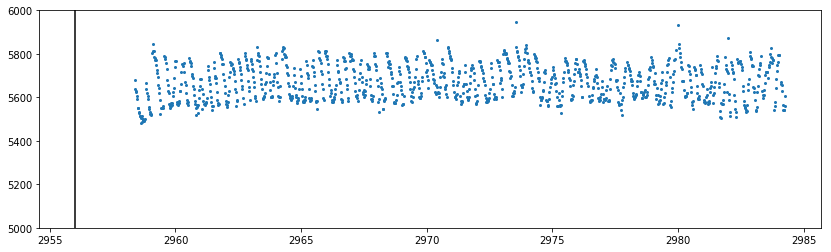

In [299]:
plt.figure(figsize=[14, 4])
plt.plot(tpf.time[q], flux[q], 'o', markersize=2)
plt.vlines(2956, ymin=5000, ymax=6000)
plt.ylim(5000, 6000)

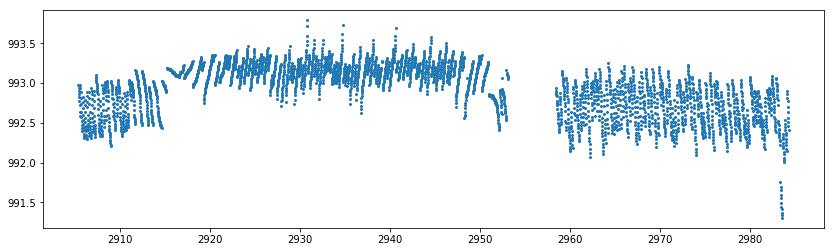

In [65]:
plt.figure(figsize=[14, 4])
plt.plot(tpf.time, col, 'o', markersize=2)

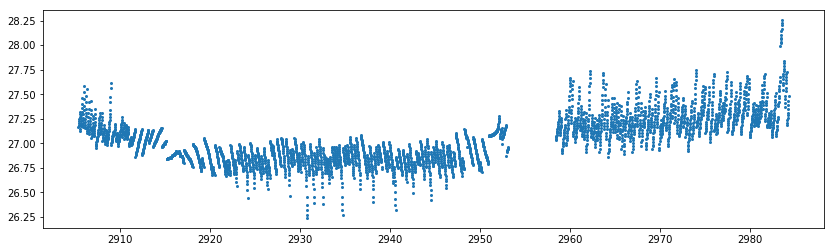

In [68]:
plt.figure(figsize=[14, 4])
plt.plot(tpf.time, row, 'o', markersize=2)

(251.22886310415029, 982.00661752378915)

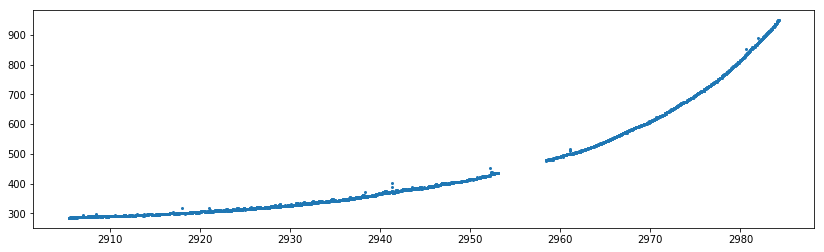

In [70]:
plt.figure(figsize=[14, 4])
plt.plot(tpf.time, bkg, 'o', markersize=2)
plt.ylim()

In [144]:
def _get_eigen_vectors(centroid_col, centroid_row):
    centroids = np.array([centroid_col, centroid_row])
    eig_val, eig_vec = np.linalg.eigh(np.cov(centroids))
    return eig_val, eig_vec

In [139]:
def _rotate(eig_vec, centroid_col, centroid_row):
    centroids = np.array([centroid_col, centroid_row])
    return np.dot(eig_vec, centroids)

In [145]:
eig_val, eig_vec = _get_eigen_vectors(col[q], row[q])

In [146]:
v1, v2 = eig_vec

In [147]:
eig_val

array([ 0.00151129,  0.11168258])

In [112]:
q = tpf.time > 2956

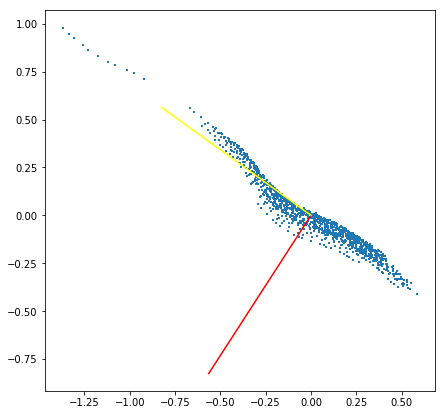

In [138]:
plt.figure(figsize=[7, 7])
plt.scatter(col[q]-np.mean(col[q]), row[q]-np.mean(row[q]), marker='+', s=2)
plt.plot([0, v1[0]], [0, v1[1]], color='red')
plt.plot([0, v2[0]], [0, v2[1]], color='yellow')

In [150]:
rot_colp, rot_rowp = _rotate(eig_vec, col[q]-np.mean(col[q]), row[q]-np.mean(row[q]))

(-1, 1)

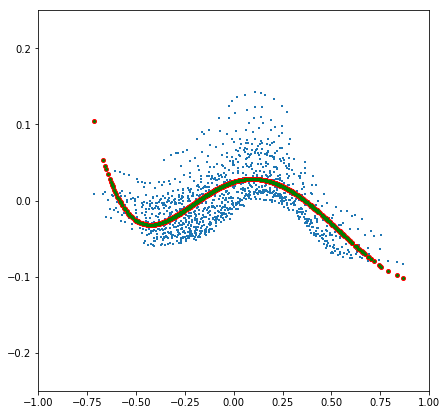

In [224]:
plt.figure(figsize=[7, 7])
plt.scatter(rot_rowp, rot_colp, marker='+', s=2)
plt.plot(rot_rowp, poly(*res.x), 'ro', markersize=4)
plt.plot(rot_rowp, p5(rot_rowp), 'go', markersize=2)
plt.ylim(-.25, .25)
plt.xlim(-1, 1)

In [153]:
# flatten flux
from pyke import LightCurve

In [ ]:
lc = LightCurve(time=)

In [194]:
def poly5(x, p):
    return p[0] + p[1] * x + p[2] * x ** 2 + p[3] * x **3 + p[4] * x ** 4 + p[5] * x ** 5

In [195]:
poly = lambda *p: poly5(rot_rowp, p)

In [218]:
from oktopus.likelihood import GaussianLikelihood as L1Norm

In [220]:
l1norm = L1Norm(data=rot_colp, mean=poly, var=1)

In [221]:
res = l1norm.fit(x0=np.zeros(6))

In [222]:
res

      fun: 0.529130207851261
 hess_inv: array([[  1.91634015e-03,   1.11367421e-03,  -1.68552351e-02,
         -1.44304848e-03,   2.69808410e-02,  -1.25476135e-02],
       [  1.11367421e-03,   3.02719511e-02,  -2.56678274e-02,
         -9.35032307e-02,   9.99368746e-02,  -2.39879698e-02],
       [ -1.68552351e-02,  -2.56678274e-02,   3.06151071e-01,
          6.32587297e-02,  -6.17216951e-01,   2.92569961e-01],
       [ -1.44304848e-03,  -9.35032307e-02,   6.32587297e-02,
          4.22474429e-01,  -3.56923792e-01,   5.37415687e-02],
       [  2.69808410e-02,   9.99368746e-02,  -6.17216951e-01,
         -3.56923792e-01,   1.65654366e+00,  -7.65981430e-01],
       [ -1.25476135e-02,  -2.39879698e-02,   2.92569961e-01,
          5.37415687e-02,  -7.65981430e-01,   3.95612313e-01]])
      jac: array([  2.72691250e-06,  -9.38028097e-06,   3.68058681e-06,
        -3.11434269e-06,  -8.19563866e-08,  -1.79558992e-06])
  message: 'Optimization terminated successfully.'
     nfev: 112
      nit

In [262]:
z = np.polyfit(rot_rowp, rot_colp, 5)

In [263]:
p5 = np.poly1d(z)

In [264]:
p5_deriv = p5.deriv()

In [265]:
rot_rowp[0], rot_rowp[-1]

(-0.35845768120620197, 0.33377535156670968)

In [266]:
rot_rowp[0] - rot_rowp[1]

-0.035175764459687731

In [267]:
xprime = np.sort(rot_rowp)

In [292]:
1 + p5_deriv(xprime[0]) ** 2

1.3616854882345146

In [298]:
s_integrand = lambda x: np.sqrt(1 + (p5_deriv(rot_rowp[:x])) ** 2)

In [294]:
s = lambda x: np.trapz(s_integrand(x), x=xprime[:x])

In [295]:
arclength = np.array([s(x) for x in range(len(rot_rowp))])

(5000, 6000)

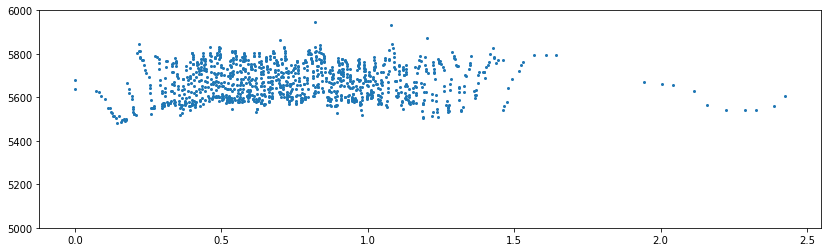

In [300]:
plt.figure(figsize=[14, 4])
plt.plot(arclength, flux[q], 'o', markersize=2)
plt.ylim(5000, 6000)